# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
train = pd.read_csv('T_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test = pd.read_csv('T_test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Подготавливаем данные

In [7]:
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)

In [12]:
train['is_test'] = 0
test['is_test'] = 1

In [11]:
df = pd.concat([train, test])

In [16]:
df['IsSex'] = df.Sex.replace({'male': 0, 'female':1})

In [31]:
df.drop(['Sex', 'PassengerId', 'Name', 'Ticket'],axis=1, inplace=True)
df.drop(['Cabin'],axis=1, inplace=True)
df.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,is_test,IsSex
0,3,22.0,1,0,7.2500,S,0,0
1,1,38.0,1,0,71.2833,C,0,1
2,3,26.0,0,0,7.9250,S,0,1
3,1,35.0,1,0,53.1000,S,0,1
4,3,35.0,0,0,8.0500,S,0,0


In [43]:
df_dummies = pd.get_dummies(df, columns=['Embarked', 'Pclass'])
df_dummies.head()

,Age,SibSp,Parch,Fare,is_test,IsSex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,0,0,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,1,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,1,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,1,0,0,1,1,0,0
4,35.0,0,0,8.0500,0,0,0,0,1,0,0,1


In [36]:
df_dummies.isnull().sum()

Age           263
SibSp           0
Parch           0
Fare            1
is_test         0
IsSex           0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Pclass_1        0
Pclass_2        0
Pclass_3        0
dtype: int64

In [51]:
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)
columns = X_train.columns

In [52]:
from sklearn.preprocessing import Imputer

In [53]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
imputer.fit(X_train)
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [54]:
X_train_imputed.head(10)

,Age,SibSp,Parch,Fare,IsSex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.000000,1.0,0.0,7.2500,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.000000,1.0,0.0,71.2833,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.000000,0.0,0.0,7.9250,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.000000,1.0,0.0,53.1000,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,35.000000,0.0,0.0,8.0500,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,29.699118,0.0,0.0,8.4583,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,54.000000,0.0,0.0,51.8625,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7,2.000000,3.0,1.0,21.0750,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,27.000000,0.0,2.0,11.1333,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9,14.000000,1.0,0.0,30.0708,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
scaler = StandardScaler()
scaler.fit(X_train_imputed)
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)
X_train_imputed_scaled.head(10)

,Age,SibSp,Parch,Fare,IsSex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,-0.592481,0.432793,-0.473674,-0.502445,-0.737695,-0.482043,-0.307562,0.619306,-0.565685,-0.510152,0.902587
1,0.638789,0.432793,-0.473674,0.786845,1.355574,2.074505,-0.307562,-1.614710,1.767767,-0.510152,-1.107926
2,-0.284663,-0.474545,-0.473674,-0.488854,1.355574,-0.482043,-0.307562,0.619306,-0.565685,-0.510152,0.902587
3,0.407926,0.432793,-0.473674,0.420730,1.355574,-0.482043,-0.307562,0.619306,1.767767,-0.510152,-1.107926
4,0.407926,-0.474545,-0.473674,-0.486337,-0.737695,-0.482043,-0.307562,0.619306,-0.565685,-0.510152,0.902587
5,0.000000,-0.474545,-0.473674,-0.478116,-0.737695,-0.482043,3.251373,-1.614710,-0.565685,-0.510152,0.902587
6,1.870059,-0.474545,-0.473674,0.395814,-0.737695,-0.482043,-0.307562,0.619306,1.767767,-0.510152,-1.107926
7,-2.131568,2.247470,0.767630,-0.224083,-0.737695,-0.482043,-0.307562,0.619306,-0.565685,-0.510152,0.902587
8,-0.207709,-0.474545,2.008933,-0.424256,1.355574,-0.482043,-0.307562,0.619306,-0.565685,-0.510152,0.902587
9,-1.208115,0.432793,-0.473674,-0.042956,1.355574,2.074505,-0.307562,-1.614710,-0.565685,1.960202,-1.107926


In [57]:
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))

In [160]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_imputed_scaled, y_train, test_size = 0.3, random_state = 0 )

## Начинаем обучение

In [77]:
from sklearn.model_selection import cross_val_score

In [97]:
depth = 5
clf = DecisionTreeClassifier( max_depth = depth )
cross_val_score( clf, X_train_imputed_scaled, y_train, cv = 5, scoring = 'accuracy' )

array([ 0.81005587,  0.82122905,  0.80898876,  0.76966292,  0.85310734])

In [139]:
# средние значения для каждого варианта max_depth
means = []
# стандартное отклонение для каждого варианта max_depth
stds = []

# считаем какое значение max_depth дает максимальную точность
for depth in range( 1, 15):
    scores = cross_val_score( DecisionTreeClassifier( max_depth = depth ), X_train_imputed_scaled, y_train, cv = 5, scoring = 'accuracy' )
    
    print( depth, scores.mean() )
    
    means.append( scores.mean() )
    stds.append( scores.std() )
max(means)    

1 0.786715024929
2 0.7733072037
3 0.809199914745
4 0.805898459706
5 0.81149774788
6 0.816004825896
7 0.806977973868
8 0.812602157539
9 0.817102958486
10 0.806990386153
11 0.794718785497
12 0.784581104885
13 0.776734767555
14 0.783476411516


0.81710295848587156

In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [101]:
cs = 10**np.linspace(-3,1,7)
grid = {'C': cs}#, 'max_features': features_num}
gridsearch = GridSearchCV(LogisticRegression(), grid, scoring='accuracy', cv=5)

In [102]:
gridsearch.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   4.64159e-03,   2.15443e-02,   1.00000e-01,
         4.64159e-01,   2.15443e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [136]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)
gridsearch.best_params_

C:\Users\Yana\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'C': 0.10000000000000001}

In [141]:
best_C = gridsearch.best_params_["C"]

In [106]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [120]:
clf1 = DecisionTreeClassifier(max_depth=6)
clf1.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [127]:
get_tree_dot_view(clf1, list(X_train_imputed_scaled.columns))

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="IsSex <= 0.309\ngini = 0.475\nsamples = 623\nvalue = [381, 242]", fillcolor="#e581395d"] ;
1 [label="Age <= -1.208\ngini = 0.315\nsamples = 408\nvalue = [328, 80]", fillcolor="#e58139c1"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="SibSp <= 1.794\ngini = 0.495\nsamples = 29\nvalue = [13, 16]", fillcolor="#399de530"] ;
1 -> 2 ;
3 [label="Parch <= 0.147\ngini = 0.111\nsamples = 17\nvalue = [1, 16]", fillcolor="#399de5ef"] ;
2 -> 3 ;
4 [label="Age <= -1.401\ngini = 0.5\nsamples = 2\nvalue = [1, 1]", fillcolor="#e5813900"] ;
3 -> 4 ;
5 [label="gini = 0.0\nsamples = 1\nvalue = [1, 0]", fillcolor="#e58139ff"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]", fillcolor="#399de5ff"] ;
4 -> 6 ;
7 [label="gini = 0.0\nsamples = 15\nvalue = [0, 15]", fillcolor="#399de5ff"] ;
3 -> 7 ;
8 [label="gini = 0.0\nsamples = 12\nvalue = [12, 0]", fillcolor="#e58139ff"] ;
2 -> 8 ;
9 [label="P

''

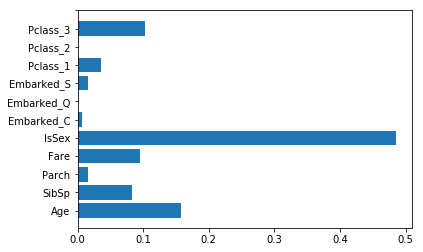

In [133]:
clf1 = DecisionTreeClassifier(max_depth=6)
clf1.fit(X_train, Y_train)

plt.barh(np.arange(len(clf1.feature_importances_)), clf1.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X_train.columns)
''

''

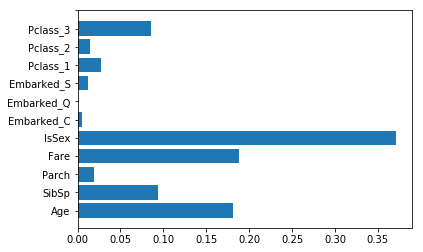

In [134]:
clf1 = DecisionTreeClassifier(max_depth=9)
clf1.fit(X_train, Y_train)

plt.barh(np.arange(len(clf1.feature_importances_)), clf1.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X_train.columns)
''

''

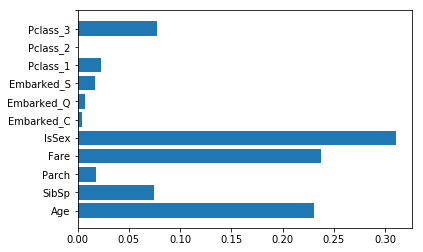

In [135]:
clf1 = DecisionTreeClassifier(max_depth=50)
clf1.fit(X_train, Y_train)

plt.barh(np.arange(len(clf1.feature_importances_)), clf1.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X_train.columns)
''

## Составляем функцию для расчёта ROC-AUC, ROC-PRC

In [173]:
predictions = clf1.predict_proba( X_test )

In [174]:
predictions[:5]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [175]:
a = zip( predictions[:, 1], Y_test )

In [176]:
from sklearn.metrics import roc_curve, precision_recall_curve

pr, re, thres = precision_recall_curve(Y_test, predictions[:, 1])

In [177]:
len( thres )

5

Populating the interactive namespace from numpy and matplotlib


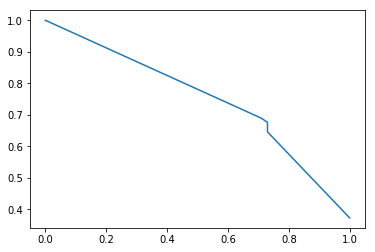

In [179]:
import pylab as pl
%pylab inline
pl.plot( re, pr )

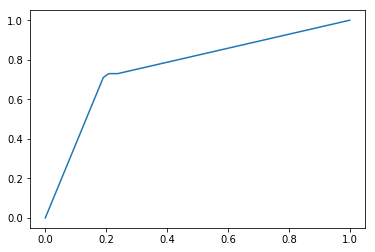

In [180]:
fpr, tpr, thres = roc_curve(Y_test, predictions[:, 1])
pl.plot( fpr, tpr )

### Используем логистическую регрессию

In [181]:
model = LogisticRegression()
model.fit( X_train, Y_train )
predictions = model.predict_proba( X_test )

In [182]:
zip( predictions[:, 1], Y_test )

In [183]:
pr, re, thres = precision_recall_curve(Y_test, predictions[:, 1])
len( thres )

240

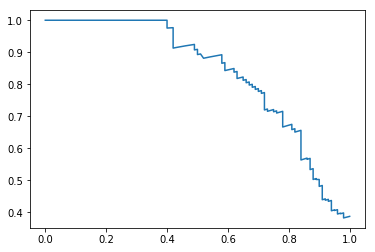

In [184]:
pl.plot( re, pr )

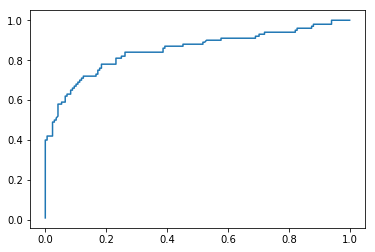

In [185]:
fpr, tpr, thres = roc_curve(Y_test, predictions[:, 1])
pl.plot( fpr, tpr )